In [13]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

# !pip install datetime
# !pip install yfinance


years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [14]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [15]:
### Download the daily adjusted close prices for the tickers
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-10-19   83.172043  51.554916  104.230003   37.740253   42.347511
2009-10-20   82.732658  51.659107  103.419998   37.749001   42.088768
2009-10-21   81.990250  51.652596  103.750000   37.679104   41.677853
2009-10-22   82.823563  51.607025  103.919998   37.827599   42.126831
2009-10-23   81.876602  51.450699  103.489998   37.670380   41.586540
...                ...        ...         ...         ...         ...
2024-10-09  577.140015  73.839996  241.050003  493.149994  284.500000
2024-10-10  576.130005  73.809998  242.820007  492.589996  283.910004
2024-10-11  579.580017  73.820000  245.470001  493.359985  286.109985
2024-10-14  584.320007  73.769997  245.070007  497.500000  288.339996
2024-10-15  581.553284  74.046600  246.154999  491.290009  287.367615

[3773 rows x 5 columns]


In [16]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-10-20 -0.005297  0.002019 -0.007802  0.000232 -0.006129
2009-10-21 -0.009014 -0.000126  0.003186 -0.001853 -0.009811
2009-10-22  0.010112 -0.000883  0.001637  0.003933  0.010715
2009-10-23 -0.011499 -0.003034 -0.004146 -0.004165 -0.012908
2009-10-26 -0.010884 -0.001266 -0.015876 -0.003251 -0.011410
...              ...       ...       ...       ...       ...
2024-10-09  0.006903 -0.002705 -0.005461  0.007838  0.006949
2024-10-10 -0.001752 -0.000406  0.007316 -0.001136 -0.002076
2024-10-11  0.005970  0.000136  0.010854  0.001562  0.007719
2024-10-14  0.008145 -0.000678 -0.001631  0.008356  0.007764
2024-10-15 -0.004746  0.003743  0.004417 -0.012561 -0.003378

[3772 rows x 5 columns]


In [17]:
# Create a function that will be used to calculate portfolio expected return
# We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [18]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.165513e-04  2.948917e-09  0.000006  1.292223e-04  1.189719e-04
BND  2.948917e-09  9.230820e-06  0.000009  8.475425e-07  1.938131e-07
GLD  6.404075e-06  8.881857e-06  0.000097  7.459276e-06  6.998955e-06
QQQ  1.292223e-04  8.475425e-07  0.000007  1.662443e-04  1.319665e-04
VTI  1.189719e-04  1.938131e-07  0.000007  1.319665e-04  1.224238e-04


In [19]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [20]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [21]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [22]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

66712.08148065447


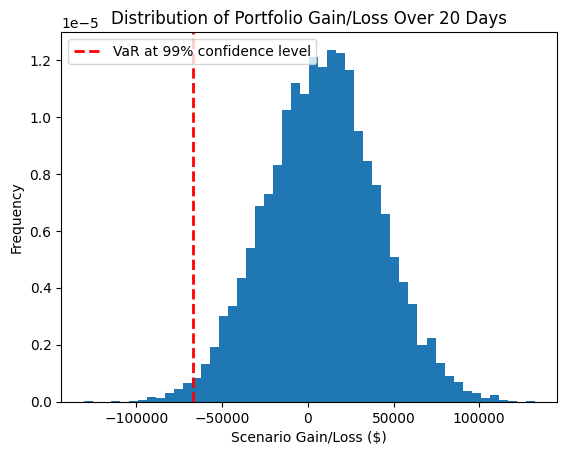

In [23]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()